In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys

# Build an Autoencoder for a human face dataset

We will use a dataset containig images of people and train an autoencoder on it. 

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [2]:
path = 'C:/Users/thula/PR autoencoder/lfw'

In [6]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")

MPS device not found.


This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [7]:
transform    = transforms.Compose([transforms.ToTensor()]) 
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)

torch.Size([250, 250, 3])


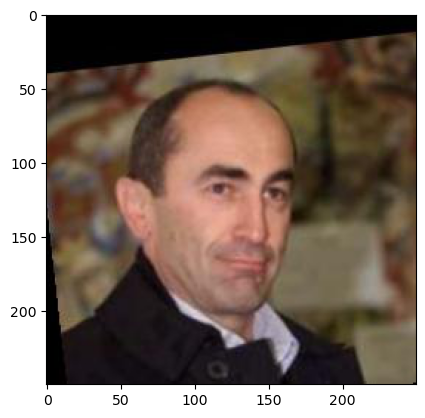

In [25]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

## Step 2
Each datapoint is an image. Get a sample of the data and print its dimensions and explain what each dimension means.

In [8]:
images, labels = next(iter(dataloader))
image_sample = images[30]
print(f"Sample image dimensions: {image_sample.shape}")
# In torch the dimensions are indicated as (C,H,W) that is (Channels, Height, Width)
# Channels : In this case , there are 3 color channels and they typically correspond to Red, Green and Blue(RGB)
# Height: 250
# width : 250
# Each pixel in the image is represented by a combination of three values (one from each channel), and each of these values contributes to the final color that is perceived at that pixel. 
# The shape [3, 250, 250] thus indicates a square RGB color image with a resolution of 250x250 pixels.

Sample image dimensions: torch.Size([3, 250, 250])


# Step 3

Create a new pytorch model calss for your autoencoder. You can use Conv2d, MaxPool2d, BatchNorm2d, ConvTranspose2d and Linear Layers as as well as activation functions. Optionally, you can use UpSample, AveragePool2d and Interpolate2d as well.

**Create seperate functions for the encoder and decoder.**

In [9]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            
        )

        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 16, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.AdaptiveAvgPool2d((250, 250)),
            nn.Conv2d(16, 3, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

## Step 4
Create an instance of the class, pass an image to the model, print the shape of the output of the **encoder** and the **decoder**. Check the dimensions and make sure your forward path is working properly.

In [10]:
transform = transforms.Compose([transforms.ToTensor()]) 
dataloader = DataLoader(ImageFolder(path, transform=transform), batch_size=32, shuffle=True)
autoencoder = Autoencoder()
images, _ = next(iter(dataloader))
image_sample = images[0].unsqueeze(0)  
with torch.no_grad():
    autoencoder.eval()  
    encoded = autoencoder.encoder(image_sample)
    decoded = autoencoder.decoder(encoded)
print(f"Shape of the encoder output: {encoded.shape}")
print(f"Shape of the decoder output: {decoded.shape}")



Shape of the encoder output: torch.Size([1, 32, 63, 63])
Shape of the decoder output: torch.Size([1, 3, 250, 250])


##  Step 5
Print total number of parameters in the model, explain what loss function you should use, create an optimizer for training

In [11]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
autoencoder = Autoencoder()
total_params = count_parameters(autoencoder)
print(f"Total number of parameters in the model: {total_params}")

Total number of parameters in the model: 17619


In [12]:
optim = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

In [13]:
loss_function=nn.MSELoss();
#Loss Function used by me is Mean Squared Error(MSE) : Because it emphasises larger errors by minimising the average of the squares of the differences between the original and reconstructed images, this is a standard choice for image reconstruction tasks.


##  Step 6
Write a training loop and start trainng the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [15]:
num_epochs = 10  

for epoch in range(num_epochs):
    total_loss = 0
    for data in dataloader:
        imgs, _ = data
        imgs = imgs.to(device)  
        outputs = autoencoder(imgs)
        loss = loss_function(outputs, imgs)
        optim.zero_grad()
        loss.backward()
        optim.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")
    
    ## There are several factors to be considered , if loss is not decreasing while training a model consists of encoder and decoder
    ## Some of the vital factors are 
            # i. Learning rate- This hyperparameter is frequently the most important one. The model might skip minima if it is set too high, and it might not converge if it is set too low. To determine an appropriate value, modify the learning rate.
            # ii.Loss Function- The most widely used loss functions for image data like this are as follows, especially when used with autoencoders for tasks like denoising, super-resolution, or feature extraction:
                                #Loss Function used by me is Mean Squared Error(MSE) : Because it emphasises larger errors by minimising the average of the squares of the differences between the original and reconstructed images, this is a standard choice for image reconstruction tasks.
            # iii. Optimizer-  ADAM(Adaptive Moment Estimation) :Adam, is a popular algorithm for handling sparse gradients on noisy problems because it combines the best features of the AdaGrad and RMSProp algorithms. It's an adaptable learning rate optimizer that works well with many different types of deep learning models.
       # some other factors are precise data preprocessing and complexity of the model   

Epoch [1/10], Loss: 0.0133
Epoch [2/10], Loss: 0.0023
Epoch [3/10], Loss: 0.0020
Epoch [4/10], Loss: 0.0018
Epoch [5/10], Loss: 0.0015
Epoch [6/10], Loss: 0.0012
Epoch [7/10], Loss: 0.0011
Epoch [8/10], Loss: 0.0011
Epoch [9/10], Loss: 0.0010
Epoch [10/10], Loss: 0.0010


##  Step 7

Take a random image from the dataset and plot it against the reconstructed (encoded + decoded) image.

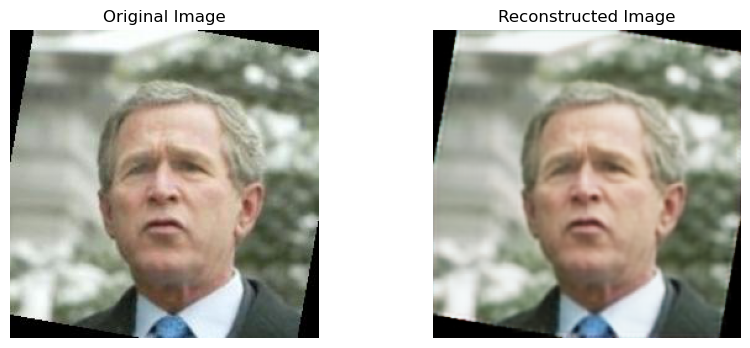

In [19]:
# Check if a GPU is available, and if not, use the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
images, _ = next(iter(dataloader))
idx = random.randint(0, images.size(0) - 1)
image_sample = images[idx].unsqueeze(0).to(device)
autoencoder.eval()  
with torch.no_grad():
    encoded = autoencoder.encoder(image_sample)
    decoded = autoencoder.decoder(encoded)
original_image = image_sample.squeeze().permute(1, 2, 0).cpu().numpy()
reconstructed_image = decoded.squeeze().permute(1, 2, 0).cpu().numpy()
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image)
plt.title('Reconstructed Image')
plt.axis('off')
plt.show()

##  Step 8

In step 7, add a small normaly distrubuted noise to the latent (hidden) representation of the input image and then decode it again. How is adding noise affecting the decoded image ?

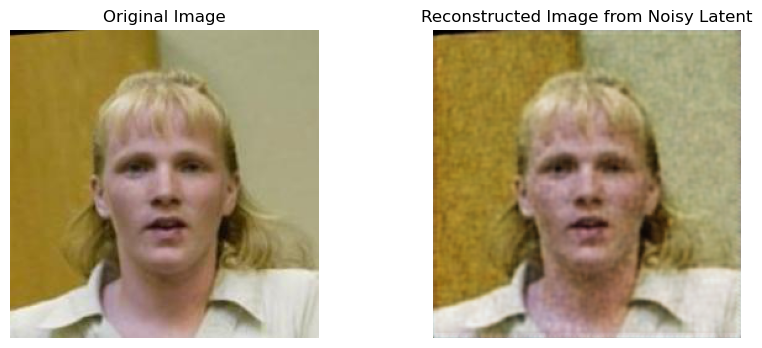

In [22]:
def add_noise(encoded, std_dev=0.1):
    noise = torch.randn_like(encoded) * std_dev
    return encoded + noise

# Assuming 'dataloader', 'autoencoder', and 'device' are already defined and initialized
images, _ = next(iter(dataloader))
idx = random.randint(0, images.size(0) - 1)
image_sample = images[idx].unsqueeze(0).to(device)

autoencoder.eval()
with torch.no_grad():
    encoded = autoencoder.encoder(image_sample)
    noisy_encoded = add_noise(encoded)
    decoded = autoencoder.decoder(noisy_encoded)

original_image = image_sample.squeeze().permute(1, 2, 0).cpu().numpy()
reconstructed_image = decoded.squeeze().permute(1, 2, 0).cpu().numpy()

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image)
plt.title('Reconstructed Image from Noisy Latent')
plt.axis('off')
plt.show()
# EFFECTS
# Reduced Clarity: The reconstructed image has lost clarity and detail as a result of the noise. It appears more hazy than the original.
# There may be subtle artifacts present in the image, which weren't there in the original. These can manifest as random splotches, color variations, or pixelations.
# Colour Shifts: Because noise in the latent space affects how these qualities are reconstructed, there may be subtle variations in colour or brightness levels.
# Potential Distortions: Certain characteristics, such as the mouth, ears, and eyes, may appear slightly warped based on the volume and kind of noise. This is due to the fact that noise might interfere with the high-level abstract properties of the images that are encoded in the latent space.
# Despite the noise, the general appearance and recognizable features of the person in the image are preserved, indicating that the network is still able to capture and reconstruct the core attributes of the input image.